In [0]:
# @title General imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPClassifier, MLPRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.neural_network._base import ACTIVATIONS
import time

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bindigit_trn.csv to bindigit_trn (1).csv
Saving bindigit_tst.csv to bindigit_tst (1).csv
Saving binMNIST.mat to binMNIST (1).mat
Saving targetdigit_trn.csv to targetdigit_trn (1).csv
Saving targetdigit_tst.csv to targetdigit_tst (1).csv
User uploaded file "bindigit_trn.csv" with length 12544000 bytes
User uploaded file "bindigit_tst.csv" with length 3136000 bytes
User uploaded file "binMNIST.mat" with length 574977 bytes
User uploaded file "targetdigit_trn.csv" with length 16000 bytes
User uploaded file "targetdigit_tst.csv" with length 4000 bytes


In [0]:
#@title Importing the data { form-width: "20%" }

bindigit_trn = np.genfromtxt('bindigit_trn.csv', delimiter=',')
targetdigit_trn = np.genfromtxt('targetdigit_trn.csv', delimiter=',')

bindigit_tst = np.genfromtxt('bindigit_tst.csv', delimiter=',')
targetdigit_tst = np.genfromtxt('targetdigit_tst.csv', delimiter=',')

In [0]:
for i in range(10):
  class_i = bindigit_trn[np.where(targetdigit_trn==i)]
  print('number of samples in class '+str(i)+' =' ,class_i.shape[0])


number of samples in class 0 = 784
number of samples in class 1 = 908
number of samples in class 2 = 826
number of samples in class 3 = 808
number of samples in class 4 = 786
number of samples in class 5 = 710
number of samples in class 6 = 767
number of samples in class 7 = 823
number of samples in class 8 = 780
number of samples in class 9 = 808


In [0]:
#@title Subsampling { form-width: "20%" }

bindigit_trn_sub = np.array([np.zeros(784)])
bindigit_tst_sub = np.array([np.zeros(784)])
targetdigit_trn_sub = np.array([])
targetdigit_tst_sub = np.array([])

for i in range(10):
  bindigit_trn_sub = np.concatenate([bindigit_trn_sub, 
                                     bindigit_trn[np.random.choice(np.where(targetdigit_trn==i)[0],80)]])
  bindigit_tst_sub = np.concatenate([bindigit_tst_sub, 
                                     bindigit_tst[np.random.choice(np.where(targetdigit_tst==i)[0],20)]])
  targetdigit_trn_sub = np.concatenate([targetdigit_trn_sub, 
                                     targetdigit_trn[np.random.choice(np.where(targetdigit_trn==i)[0],80)]])
  targetdigit_tst_sub = np.concatenate([targetdigit_tst_sub, 
                                     targetdigit_tst[np.random.choice(np.where(targetdigit_tst==i)[0],20)]])
  
bindigit_trn_sub = bindigit_trn_sub[1:]
bindigit_tst_sub = bindigit_tst_sub[1:]

np.random.shuffle(bindigit_trn_sub)
np.random.shuffle(bindigit_tst_sub)
np.random.shuffle(targetdigit_trn_sub)
np.random.shuffle(targetdigit_tst_sub)

In [0]:
# FOR ALBAN WHO CANT UPLOAD SHIT
from google.colab import drive
drive.mount('/content/drive')

bindigit_trn = np.genfromtxt('/content/drive/My Drive/data/bindigit_trn.csv', delimiter=',')
targetdigit_trn = np.genfromtxt('/content/drive/My Drive/data/targetdigit_trn.csv', delimiter=',')

bindigit_tst = np.genfromtxt('/content/drive/My Drive/data/bindigit_tst.csv', delimiter=',')
targetdigit_tst = np.genfromtxt('/content/drive/My Drive/data/targetdigit_tst.csv', delimiter=',')

KeyboardInterrupt: ignored

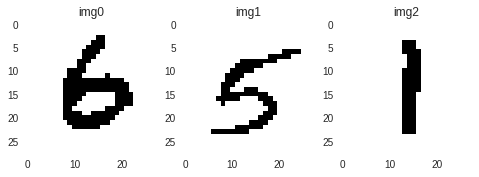

In [0]:
def display(p,ax,title):
  img = np.reshape(p, (28,28))
  imgplot = ax.imshow(img) #we should add cmap='gray'
  ax.set_title(title);

fig,(ax1,ax2,ax3) = plt.subplots(nrows = 1, ncols=3)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
display(bindigit_trn[0,:], ax1, 'img0')
display(bindigit_trn[3,:], ax2, 'img1')
display(bindigit_trn[2,:], ax3, 'img2');

# 3.1 Autoencoder features for binary-type MNIST images

In [0]:
#@title Mean error function { form-width: "20%" }
import time 

def mean_error(y1, y2):
  err = np.sum(np.mean(np.absolute(y1-y2), axis=1), axis=0)
  return err

In [0]:
#@title Structure of the network { form-width: "20%" }

N_hidden = 100
nfeatures = 784
dimTarget = nfeatures

#add bias later
W = np.random.normal(0, 0.1, (nfeatures, N_hidden)) 
V = np.random.normal(0, 0.1, (N_hidden, dimTarget))

reg = 0.001
eta = 0.015
max_iter = 1

In [0]:
 #@title Building the Autoencoder { form-width: "20%" }


def build(N_hidden, W,V,eta, reg, max_iter ):
  ae = MLPClassifier(hidden_layer_sizes = (N_hidden,), 
                    activation = 'logistic', solver = 'sgd', 
                    max_iter = max_iter, alpha = reg, warm_start = True,
                    learning_rate = 'constant',learning_rate_init = eta)

  ae.intercepts_ = [ np.zeros(N_hidden) , np.zeros(nfeatures) ]
  ae.coefs_ = [ W , V ]

  ae = MLPClassifier(hidden_layer_sizes = (N_hidden,), 
                    activation = 'logistic', solver = 'sgd', 
                    max_iter = max_iter, alpha = reg, warm_start = True,
                    learning_rate = 'constant',learning_rate_init = eta)
  return ae

#### Attention : c bon comme ca plus besoin de relancer avec et sans commentaires (LOURD)
# 

In [0]:
#@title Training and testing the Autoencoder { form-width: "20%" }


def train_test_errors(ae, N_epochs, trainset, testset):
  #Function that fits the autoencoder and returns the train and test error 
  
  trn_errors, tst_errors = [], []
  for i in range(N_epochs):

    if(i%10==0):
      print(i)
    ae.fit(trainset, trainset)

    #Training error
    predict_trn = ae.predict(trainset)
    trn_error = mean_error(predict_trn, trainset)
    trn_errors.append(trn_error)

    #Test error
    predict_tst = ae.predict(testset)
    tst_error = mean_error(predict_tst, testset)
    tst_errors.append(tst_error)
    
  return trn_errors, tst_errors

In [0]:
#@title Activation results of the hidden layer of the Autoencoder { form-width: "20%" }

def hidden_activation_results(ae, inp ):   
  
  # the hidden activation results
  hidden_act = ACTIVATIONS['logistic'](np.matmul(inp, ae.coefs_[0]) + ae.intercepts_[0])
  return hidden_act

In [0]:
#@title Plotting the error { form-width: "20%" }
def plotting_errors(trn_errors,tst_errors,N_epochs,  title, separate =False):
  if separate :
    fig,(ax1,ax2) = plt.subplots(nrows = 1, ncols=2)
    ax1.grid(False)
    ax2.grid(False)

    #plt.figure(1)
    ax1.plot(np.arange(1,N_epochs+1),trn_errors,color='r')
    ax1.set_title("Training error "+title)
    ax1.set_xlabel('Number of epochs')
    ax1.set_xlabel('Total error')

    #plt.figure(2)
    ax2.plot(np.arange(1,N_epochs+1),tst_errors,color='b')
    ax2.set_title("Test error "+title)
    ax2.set_xlabel('Number of epochs')
    ax2.set_xlabel('Total error')
    
    
  else :
    plt.figure()
    plt.plot(np.arange(1,N_epochs+1),trn_errors,color='b')
    plt.plot(np.arange(1,N_epochs+1),tst_errors,color='r')
    plt.legend(["Training error", "Test error"])
    plt.title("Total error as a function of the epochs: "+title)
    plt.xlabel("Number of epochs")
    plt.ylabel("Total error")
    plt.show()


In [0]:
ae = build(N_hidden, W,V,eta, reg, max_iter)

In [0]:
N_epoch=100
trn_errors, tst_errors = train_test_errors(ae, N_epoch ,bindigit_trn , bindigit_tst)

0
10
20
30
40
50
60
70
80
90


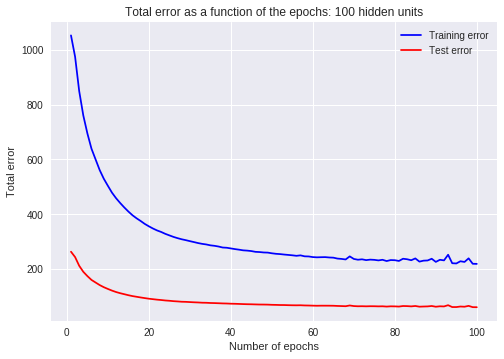

train/test error: 218.07270408163265 59.628826530612244


In [0]:
plotting_errors(trn_errors,tst_errors,N_epoch, str(N_hidden)+' hidden units',separate = False)

print('train/test error:',trn_errors[N_epoch-1],tst_errors[N_epoch-1] )

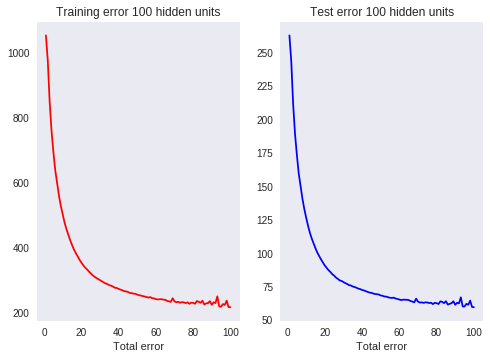

In [0]:
N_epochs=100

plotting_errors(trn_errors,tst_errors,N_epochs, str(N_hidden)+' hidden units',separate = True)

In [0]:
hidden_act = hidden_activation_results(ae, bindigit_trn )

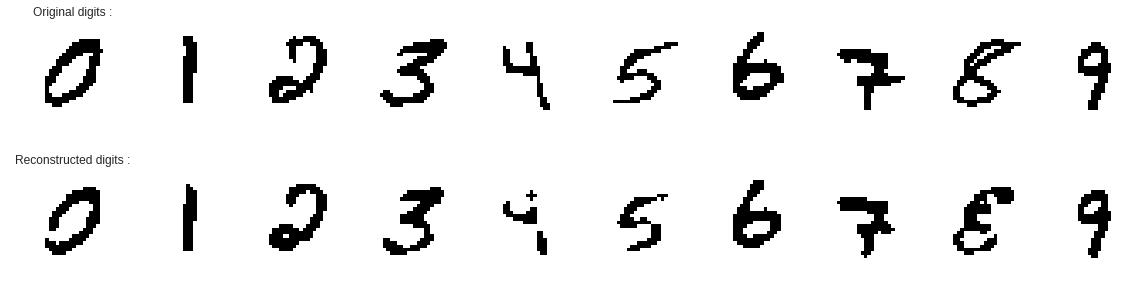

In [0]:
# @title Reconstructing images { form-width: "20%" }

N_rows = 2
N_cols = 10

reconstructed_imgs = ae.predict(bindigit_trn)

fig,ax = plt.subplots(nrows = N_rows, ncols = N_cols, figsize=(20,5))

index = [11, 2, 36, 15, 6, 3, 0, 4, 31, 9]

ax[0][0].axis('off')
display(bindigit_trn[index[0]], ax[0][0], 'Original digits :')
  
ax[1][0].axis('off')
display(reconstructed_imgs[index[0]], ax[1][0], 'Reconstructed digits :')

for k in range (1,10):
  ax[0][k].axis('off')
  display(bindigit_trn[index[k]], ax[0][k], ' ')
  
  ax[1][k].axis('off')
  display(reconstructed_imgs[index[k]], ax[1][k], ' ')
  

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


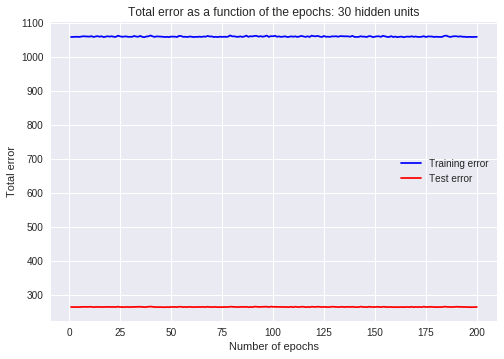

train/test error: 1059.170918367347 264.23852040816325
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


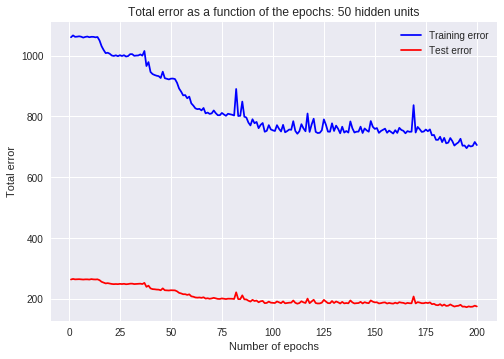

train/test error: 705.969387755102 175.65561224489795
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


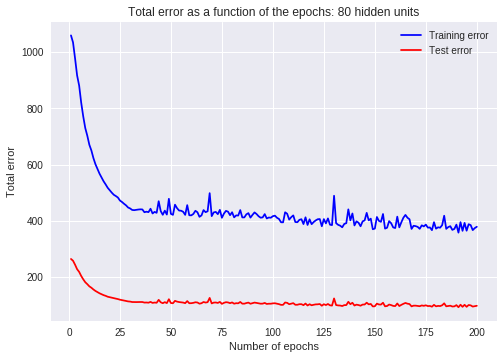

train/test error: 378.5841836734694 97.68239795918367
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


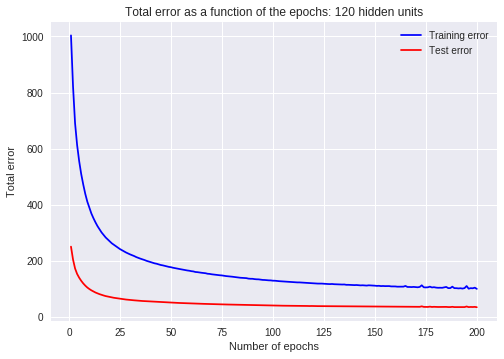

train/test error: 99.26913265306122 33.75892857142857
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


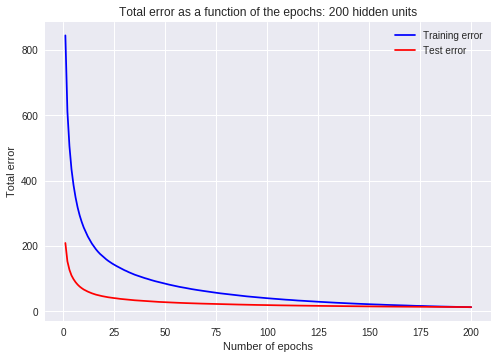

train/test error: 12.373724489795919 12.761479591836736


In [0]:
#@title Different sizes of the hidden layer representation (Compact code) { form-width: "20%" }

hidden_act_dict_trn = {}
hidden_act_dict_tst = {}
N_epoch = 200
for N_hidden in [30,50,80,120,200]:
  W = np.random.normal(0, 0.1, (nfeatures, N_hidden)) 
  V = np.random.normal(0, 0.1, (N_hidden, dimTarget))
  
  # build the autoencoder with N_hidden units
  globals()['ae_%s' % N_hidden]= build(N_hidden, W,V,eta, reg, max_iter)
  
  #train and test errors
  trn_errors, tst_errors = train_test_errors(globals()['ae_%s' % N_hidden], N_epoch ,bindigit_trn , bindigit_tst)
  
  #add to the dictionary the hidden_activation results (training set and test set)
  hidden_act_dict_trn[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_trn )
  hidden_act_dict_tst[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_tst )
  
  #plotting the train and test error
  plt.figure()
  plotting_errors(trn_errors,tst_errors,N_epoch, str(N_hidden)+' hidden units', separate=False)
  
  print('train/test error:',trn_errors[N_epoch-1],tst_errors[N_epoch-1] )


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


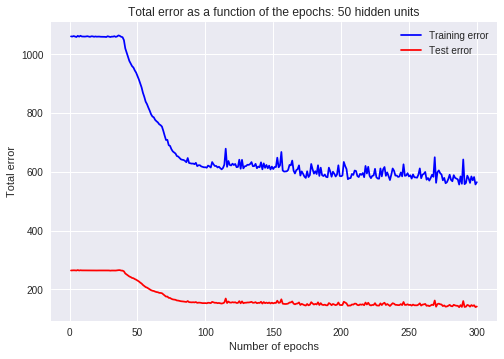

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


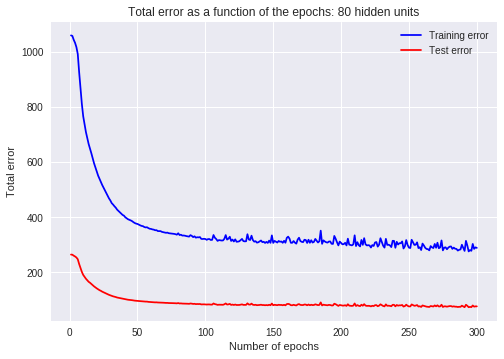

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


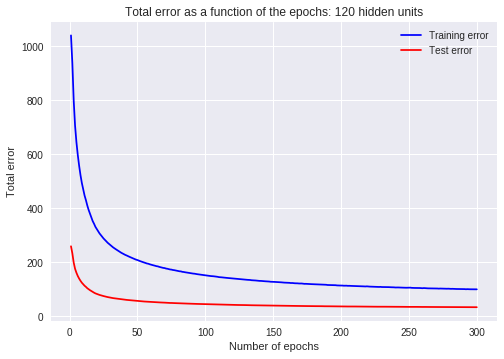

In [0]:
#@title Trying with 50, 80 and 120 hidden units (one hidden layer) { form-width: "20%" }
N_epoch = 300
# avec 100 le training n'est pas fini 

for N_hidden in [50,80,120]:
  W = np.random.normal(0, 0.1, (nfeatures, N_hidden)) 
  V = np.random.normal(0, 0.1, (N_hidden, dimTarget))
  
  # build the autoencoder with N_hidden units
  globals()['ae_%s' % N_hidden]= build(N_hidden, W,V,eta, reg, max_iter)
  
  #train and test errors
  trn_errors, tst_errors = train_test_errors(globals()['ae_%s' % N_hidden], N_epoch ,bindigit_trn , bindigit_tst)
  
  #add to the dictionary the hidden_activation results
  hidden_act_dict_trn[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_trn )
  hidden_act_dict_tst[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_tst )
  
  #plotting the train and test error
  plt.figure()
  plotting_errors(trn_errors,tst_errors,N_epoch, str(N_hidden)+' hidden units', separate=False)


0
10
20
30
40
50
60
70
80
90


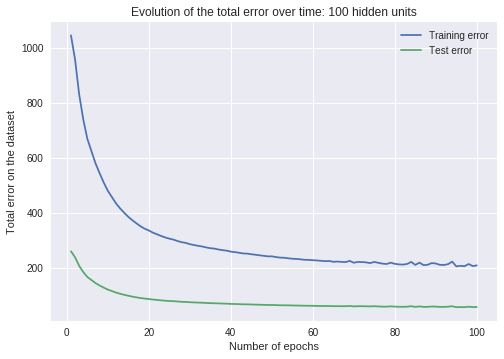

In [0]:
#@title Different sizes of the hidden layer representation { form-width: "20%" }
 
hidden_act_dict = {}

for N_hidden in [100]:
  W = np.random.normal(0, 0.1, (nfeatures, N_hidden)) 
  V = np.random.normal(0, 0.1, (N_hidden, dimTarget))
  
  
  ae.intercepts_ = [ np.zeros(N_hidden) , np.zeros(nfeatures) ]
  ae.coefs_ = [ W , V ]
  ae = MLPClassifier(hidden_layer_sizes = (N_hidden,), 
                    activation = 'logistic', solver = 'sgd', 
                    max_iter = 1, alpha = reg, warm_start = True,
                    learning_rate = 'constant',learning_rate_init = 0.015)
  
  globals()['ae%s' % N_hidden]= ae
  N_epochs = 100
  trn_errors, tst_errors = [], []

  for i in range(N_epochs):
    
    if(i%10==0):
      print(i)
    
    ae.fit(bindigit_trn, bindigit_trn)

    #Training error
    predict_trn = ae.predict(bindigit_trn)
    trn_error = mean_error(predict_trn, bindigit_trn)
    trn_errors.append(trn_error)

    #Test error
    predict_tst = ae.predict(bindigit_tst)
    tst_error = mean_error(predict_tst, bindigit_tst)
    tst_errors.append(tst_error)
    
    # the hidden activation results
    hidden_act = ACTIVATIONS['logistic'](np.matmul(bindigit_trn, ae.coefs_[0]) + ae.intercepts_[0])
    hidden_act_dict[N_hidden] = hidden_act
    
  plt.plot(np.arange(1,N_epochs+1),trn_errors)
  plt.plot(np.arange(1,N_epochs+1),tst_errors)
  plt.legend(["Training error", "Test error"])
  plt.title("Evolution of the total error over time: "+str(N_hidden)+" hidden units")
  plt.xlabel("Number of epochs")
  plt.ylabel("Total error on the dataset")
  plt.show()


In [0]:
#Threshold of sparseness is 0.5

def sparseness(matrix,threshold, epsilon):
  s = []
  for i in range(matrix.shape[0]):
    vector = matrix[i,:]
    sparseness = vector[np.where(abs(vector-threshold) > epsilon)].shape[0]
    s.append(sparseness)
  sparseness_vector = np.array(s)
  return sparseness_vector

#matrix = np.array([[0,1,2,10,4,0,0],[1,0,1,0,1,1,2]])
#a = sparseness(matrix, 0.5)
#print(type(a))
#print(a)
  
average_sparseness =  np.mean(sparseness(hidden_act,0.5,10**-8))


In [0]:
#@title Effect of the regularisation { form-width: "20%" }

for N_hidden in [200,120,80,50,30]: 
  hidden_act = hidden_act_dict_trn[N_hidden]
  
  average_sparseness =  np.mean(sparseness(hidden_act,0,1e-5))
  print('for '+ str(N_hidden)+' layers', average_sparseness)
  
# il faut verifier la formule

for 200 layers 200.0
for 120 layers 120.0
for 80 layers 79.998875
for 50 layers 49.999875
for 30 layers 30.0


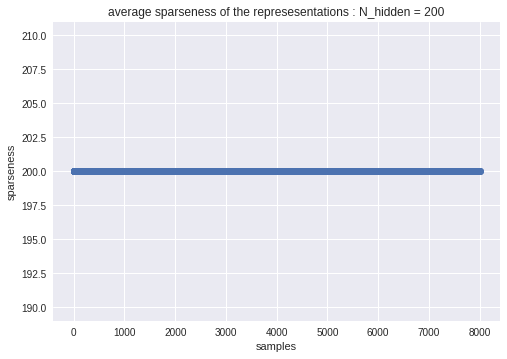

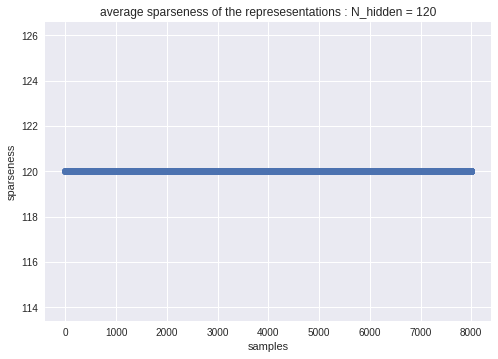

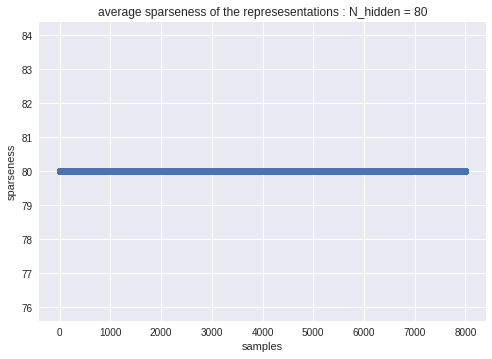

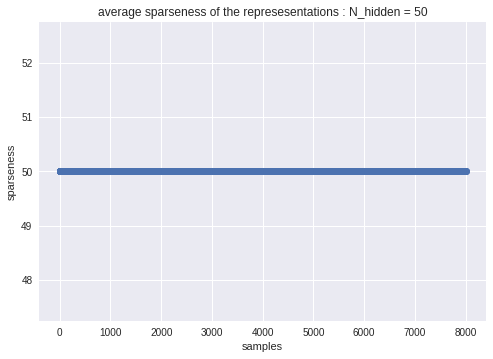

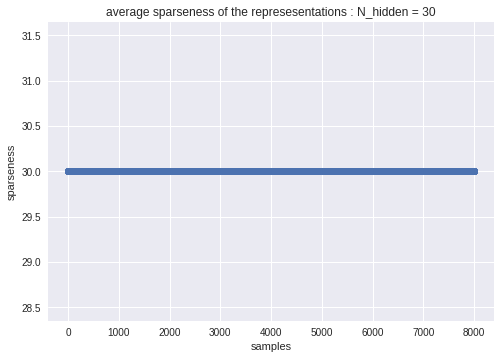

type of the output of the hidden layer <class 'numpy.ndarray'>
shape of the output of the hidden layer (8000, 30)


In [0]:
#@title Effect of the regularisation { form-width: "20%" }

for N_hidden in [200,120,80,50,30]: 
  hidden_act = hidden_act_dict_trn[N_hidden]
  
  average_sparseness =  np.mean(sparseness(hidden_act,0.5,10**-8))
  plt.figure()
  plt.plot(sparseness(hidden_act,0.5,10**-8), 'o')
  plt.xlabel('samples')
  plt.ylabel('sparseness')
  plt.title('average sparseness of the represesentations : N_hidden = ' + str(N_hidden))
  plt.show()
  
  
print ('type of the output of the hidden layer',type(hidden_act_dict_trn[N_hidden]))
print ('shape of the output of the hidden layer',np.shape(hidden_act_dict_trn[N_hidden]))
# il faut verifier la formule

Sparse representations


*    promoting memory capacity
*   orthogonalisation/decorrelation
* “metabolic” efficiency
* neural selectivity (vs coarse coding with broad tuning)

In [0]:
#@title measure the average sparseness of hidden layer representations { form-width: "20%" }


In [0]:
# @title Plotting the weights for each unit

def plot_weights(N_hidden,ae):

  N_rows = int(N_hidden / 10)
  N_cols = 10

  fig, axes = plt.subplots(nrows=N_rows,ncols= N_cols, figsize = (2*N_cols,2*N_rows))
  ax_list = fig.axes
  for i in range(N_rows*N_cols):
    ax = ax_list[i]
    ax.axis('off')
    display(ae.coefs_[0][:,i], ax, ' ')

  

Number of hidden nodes : 50
Number of hidden nodes : 80
Number of hidden nodes : 120


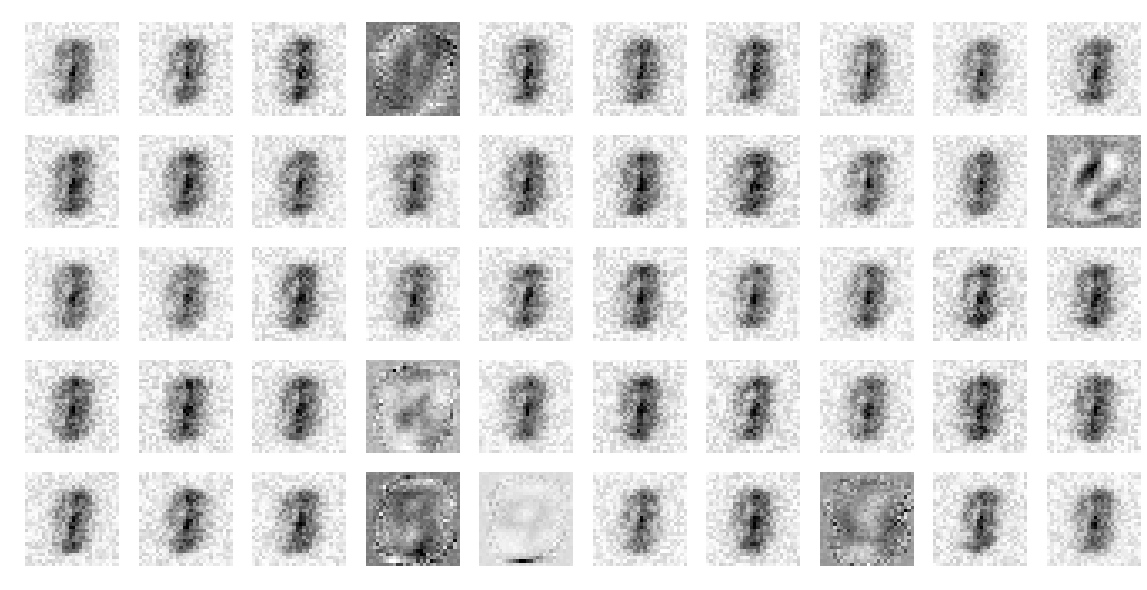

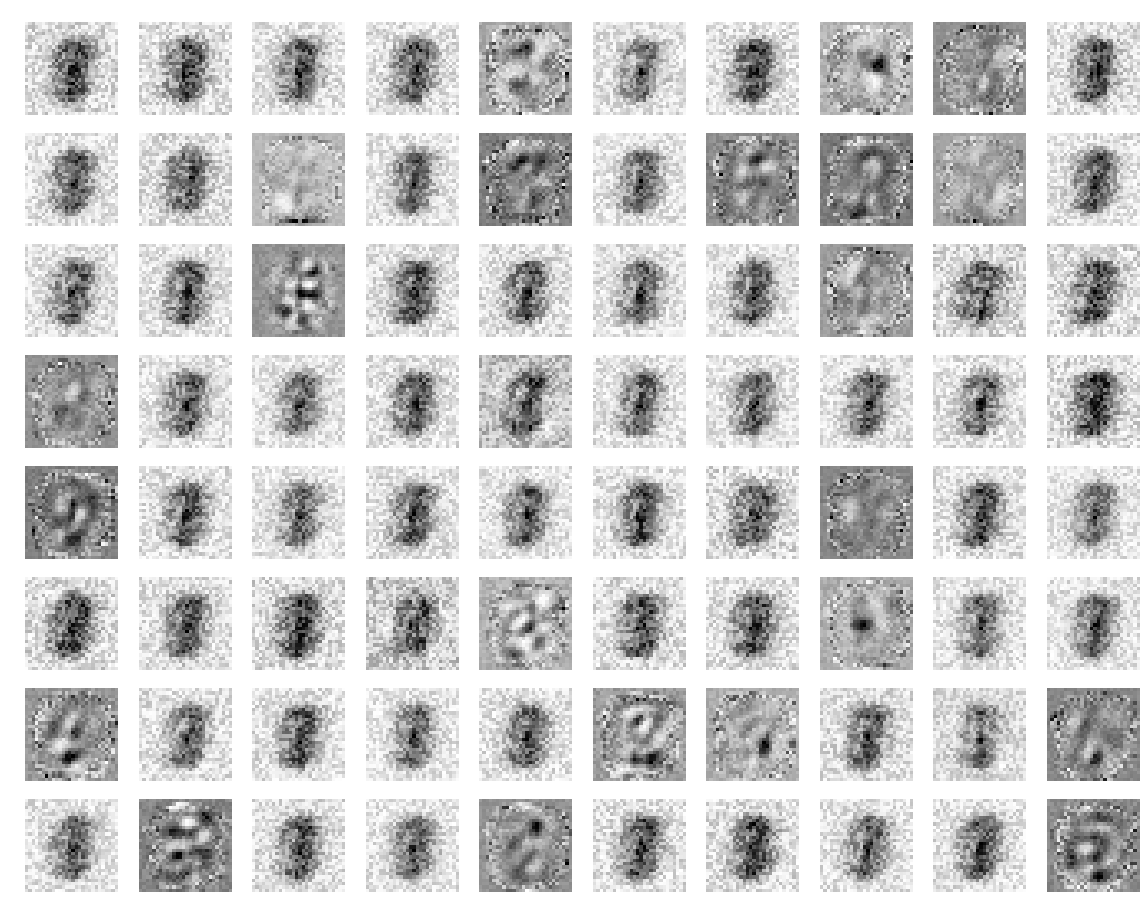

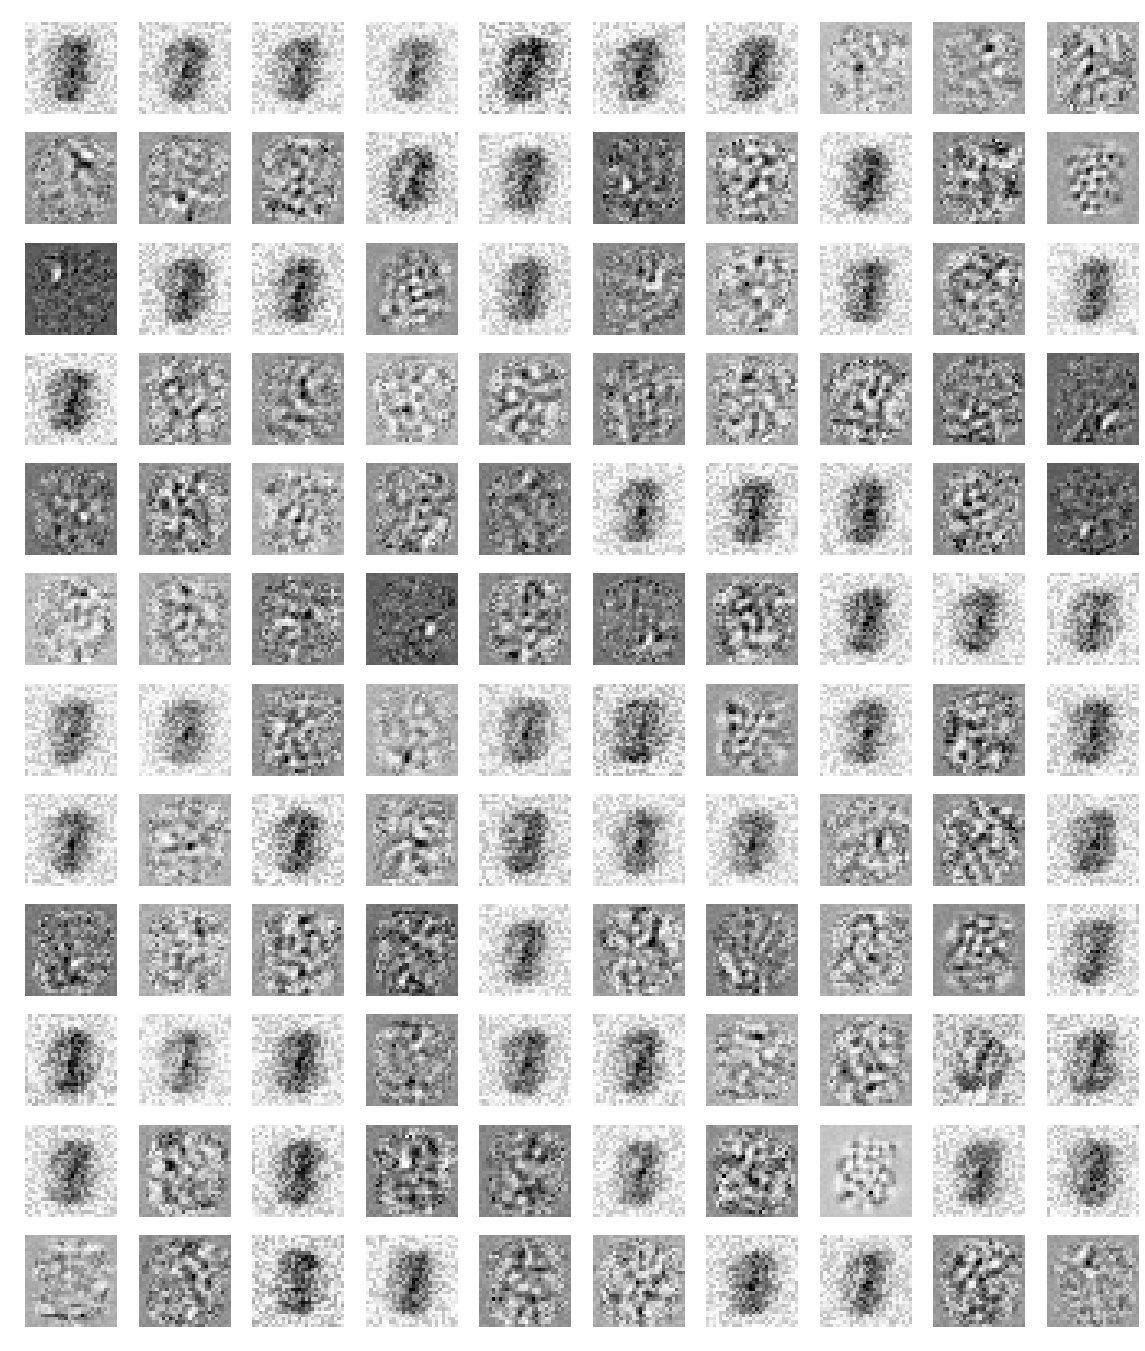

In [0]:
for N_hidden in [50, 80, 120]:
  
  print('Number of hidden nodes : '+ str(N_hidden))
  plot_weights(N_hidden, globals()['ae_%s' % N_hidden])

# 3.2 Stacked autoencoders for MNIST digit classification

## 3.2.1 Classification with deeper architectures

In [0]:
def build_regressor(N_input,N_hidden, W,V,eta, reg, max_iter ):
  ae = MLPRegressor(hidden_layer_sizes = (N_hidden,), 
                    activation = 'logistic', solver = 'sgd', 
                    max_iter = max_iter, alpha = reg, warm_start = True,
                    learning_rate = 'constant',learning_rate_init = eta)

  ae.intercepts_ = [ np.zeros(N_hidden) , np.zeros(N_input) ]
  ae.coefs_ = [ W , V ]

  ae = MLPRegressor(hidden_layer_sizes = (N_hidden,), 
                    activation = 'logistic', solver = 'sgd', 
                    max_iter = max_iter, alpha = reg, warm_start = True,
                    learning_rate = 'constant',learning_rate_init = eta)
  return ae

0
10
20
30
40
50
60
70
80
90


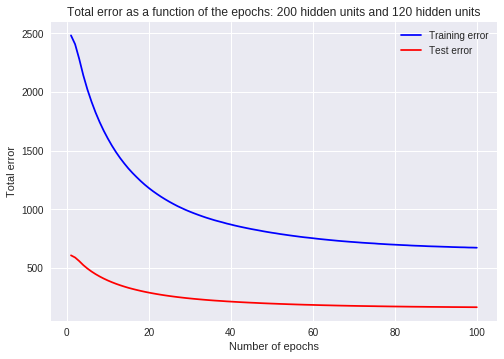

0
10
20
30
40
50
60
70
80
90


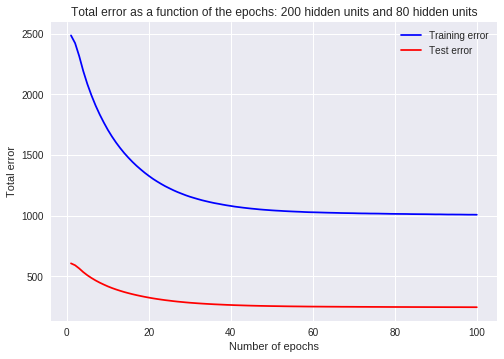

0
10
20
30
40
50
60
70
80
90


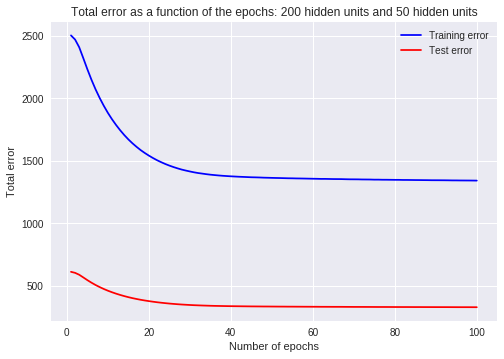

0
10
20
30
40
50
60
70
80
90


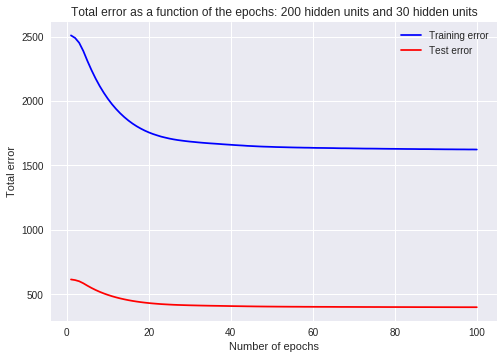

0
10
20
30
40
50
60
70
80
90


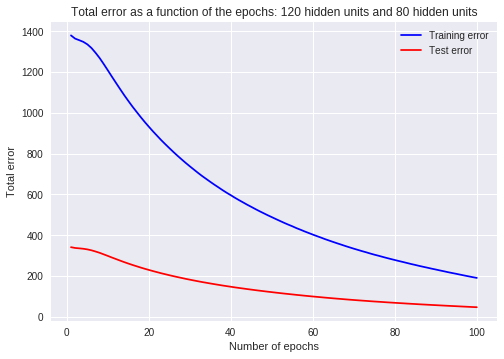

0
10
20
30
40
50
60
70
80
90


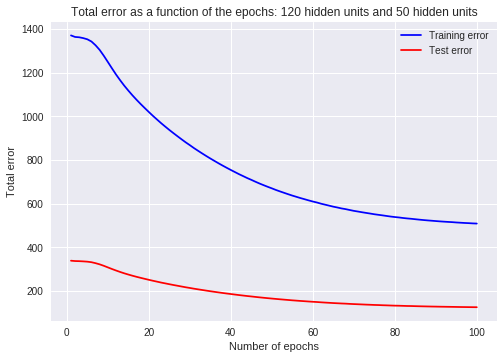

0
10
20
30
40
50
60
70
80
90


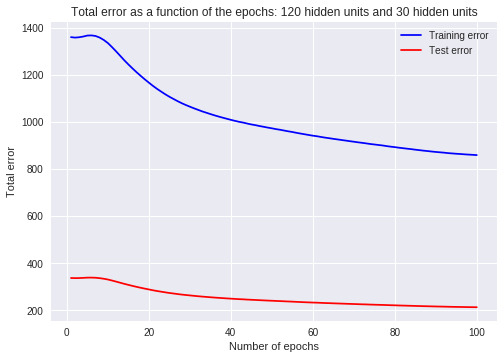

0
10
20
30
40
50
60
70
80
90


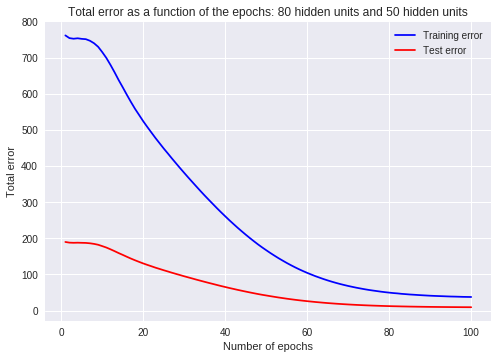

0
10
20
30
40
50
60
70
80
90


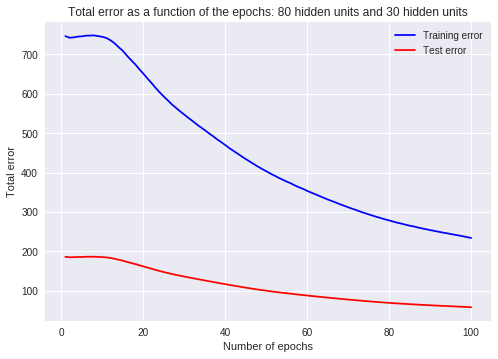

0
10
20
30
40
50
60
70
80
90


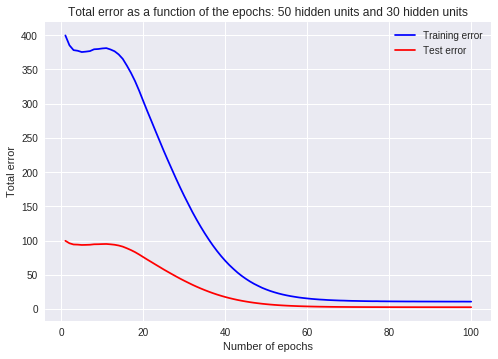

In [0]:
#@title 2 Hidden layers : fix output of different N_hidden_1 and explore N_hidden_2 { form-width: "20%" }

# parameters 

reg = 0.001
eta = 0.01
max_iter = 1
possible_values = [200,120,80,50,30]

N_epoch = 100

  
hidden_2_act_dict_trn ={}
hidden_2_act_dict_tst ={}
for N_hidden_1 in [200,120,80,50]:

  
  N_hidden_2_values = [value for value in possible_values if (value < N_hidden_1)]
  
  for N_hidden_2 in N_hidden_2_values:
    
    W_2 = np.random.normal(0, 0.1, (N_hidden_1, N_hidden_2))
    V_2 = np.random.normal(0, 0.1, (N_hidden_2, N_hidden_1))

    # build the autoencoder with N_hidden units
    globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)]= build_regressor(N_hidden_1, N_hidden_2, W_2, V_2, eta, reg, max_iter)

    #train and test errors
    trn_errors, tst_errors = train_test_errors(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)], N_epoch ,hidden_act_dict_trn[N_hidden_1],hidden_act_dict_tst[N_hidden_1])

    
    
    
    ## Attention : les erreurs ici sont par rapport au output de la hidden layer et pas du input de base 
    
    
    
    
    #add to the dictionary the hidden_activation results
    hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)] = hidden_activation_results(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)],
                                                                  hidden_act_dict_trn[N_hidden_1] )
    hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)] = hidden_activation_results(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)],
                                                                  hidden_act_dict_tst[N_hidden_1] )
    #plotting the train and test error
    plt.figure()
    plotting_errors(trn_errors,tst_errors,N_epoch,
                    str(N_hidden_1)+' hidden units and '+str(N_hidden_2)+' hidden units', separate=False)


In [0]:
# @title  3 Hidden layers : fix N_hidden_1, variate N_hidden_2 and N_hidden_3
t_0 = time.time()
# parameters 
N_hidden_1 =120


reg = 0.001
eta = 0.01
max_iter = 1

possible_values = [120, 80, 50, 30]
N_epoch = 100
  
hidden_3_act_dict_trn ={}
hidden_3_act_dict_tst ={}
#fixed
for N_hidden_2 in [120,100,80,50]:

  
  N_hidden_3_values = [value for value in possible_values if value <= N_hidden_2]
  
  for N_hidden_3 in N_hidden_3_values:
    W_3 = np.random.normal(0, 0.1, (N_hidden_2, N_hidden_3))
    V_3 = np.random.normal(0, 0.1, (N_hidden_3, N_hidden_2))

    # build the autoencoder with N_hidden units
    globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)]= build_regressor(N_hidden_2,N_hidden_3, W_3, V_3, eta, reg, max_iter)

    #train and test errors
    trn_errors, tst_errors = train_test_errors(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)], N_epoch ,
                                               hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)],
                                               hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)])

    #add to the dictionary the hidden_activation results
    hidden_3_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)+'_'+ str(N_hidden_3)] = hidden_activation_results(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)],
                                                                  hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)] )
    hidden_3_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)+'_'+ str(N_hidden_3)] = hidden_activation_results(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)],
                                                                  hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)] )
    #plotting the train and test error
    plt.figure()
    plotting_errors(trn_errors,tst_errors,N_epoch,
                    str(N_hidden_1)+' hidden units and '+str(N_hidden_2)+' hidden units'+str(N_hidden_3)+' hidden units', separate=False)
t_1=time.time
print('total time ', t_1 - t_0)

KeyError: ignored

## A network configuration with a simple classication layer operating directly on the raw inputs as the no-hidden-layer option

In [0]:
#@title Gradient Descent zith configuration 120_100_80 { form-width: "20%" }
from sklearn import linear_model

X = hidden_3_act_dict_trn['120_100_80']
y = targetdigit_trn

clf = linear_model.SGDClassifier(max_iter=1000)

clf.fit(X, y)

pred = clf.predict(hidden_3_act_dict_tst['120_100_80'])
clf.score(hidden_3_act_dict_tst['120_100_80'], targetdigit_tst)


In [0]:
#@title logistic regression with configuration 120_100_80 { form-width: "20%" }
from sklearn.linear_model import LogisticRegression

logisticRegr= LogisticRegression(random_state=0, solver='saga',multi_class='multinomial').fit(X, y)
pred = logisticRegr.predict(hidden_3_act_dict_tst['120_100_80'])

print('prediction',pred)
print('target', targetdigit_tst)

logisticRegr.predict_proba(hidden_3_act_dict_tst['120_100_80']) 
score = logisticRegr.score(hidden_3_act_dict_tst['120_100_80'], targetdigit_tst)
print('score ', score)


In [0]:
ae = MLPClassifier(hidden_layer_sizes = (120,80,5°),
                    activation = 'logistic',
                    learning_rate='adaptive', 
                    #early_stopping = True, 
                    alpha = reg, 
                    max_iter = 100)

In [0]:
# @title Fine tuning of the network


ae.coefs_ = [ae_120.coefs_,
             ae_120_100.coefs_,
             ae_120_100_80.coefs_, logisticRegr.coef_]
ae.intercepts_ = [ae_120.intercepts_, 
                  ae_120_100.intercepts_, 
                  ae_120_100_80.intercepts_,
                  logisticRegr.intercept_]


ae = MLPClassifier(hidden_layer_sizes = (120,100,80),
                    activation = 'logistic',
                    learning_rate='adaptive', 
                    #early_stopping = True, 
                    alpha = reg, 
                    max_iter = 100)

ae.fit(bindigit_trn, targetdigit_trn)

ae.score(bindigit_tst, targetdigit_tst)

In [0]:
N_epoch = 100
nfeatures = 784
dimTarget = 784
N_hidden = 120
eta = 0.015
reg = 0.001
max_iter = 100
hidden_act_dict_trn = {}
hidden_act_dict_tst = {}

W = np.random.normal(0, 0.1, (nfeatures, N_hidden)) 
V = np.random.normal(0, 0.1, (N_hidden, dimTarget))
  
# build the autoencoder with N_hidden units
globals()['ae_%s' % N_hidden]= build(N_hidden, W,V,eta, reg, max_iter)
  
#train and test errors
trn_errors, tst_errors = train_test_errors(globals()['ae_%s' % N_hidden], N_epoch ,bindigit_trn , bindigit_tst)
  
#add to the dictionary the hidden_activation results
hidden_act_dict_trn[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_trn )
hidden_act_dict_tst[N_hidden] = hidden_activation_results(globals()['ae_%s' % N_hidden], bindigit_tst )
  
#plotting the train and test error
plt.figure()
plotting_errors(trn_errors,tst_errors,N_epoch, str(N_hidden)+' hidden units', separate=False)

In [0]:
#@title 2 Hidden layers : fix output of different N_hidden_1 and explore N_hidden_2 { form-width: "20%" }

# parameters 

reg = 0.001
eta = 0.01
max_iter = 1
possible_values = [200, 150, 120,100, 80, 50, 30]

N_epoch = 100

  
hidden_2_act_dict_trn ={}
hidden_2_act_dict_tst ={}
for N_hidden_1 in [120]:

  
  #N_hidden_2_values = [value for value in possible_values if (value < N_hidden_1)]
  
  for N_hidden_2 in [100]:
    
    W_2 = np.random.normal(0, 0.1, (N_hidden_1, N_hidden_2))
    V_2 = np.random.normal(0, 0.1, (N_hidden_2, N_hidden_1))

    # build the autoencoder with N_hidden units
    globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)]= build_regressor(N_hidden_1, N_hidden_2, W_2, V_2, eta, reg, max_iter)

    #train and test errors
    trn_errors, tst_errors = train_test_errors(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)], N_epoch ,hidden_act_dict_trn[N_hidden_1],hidden_act_dict_tst[N_hidden_1])

    
    
    
    ## Attention : les erreurs ici sont par rapport au output de la hidden layer et pas du input de base 
    
    
    
    
    #add to the dictionary the hidden_activation results
    hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)] = hidden_activation_results(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)],
                                                                  hidden_act_dict_trn[N_hidden_1] )
    hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)] = hidden_activation_results(globals()['ae_%s_%s' % (N_hidden_1, N_hidden_2)],
                                                                  hidden_act_dict_tst[N_hidden_1] )
    #plotting the train and test error
    plt.figure()
    plotting_errors(trn_errors,tst_errors,N_epoch,
                    str(N_hidden_1)+' hidden units and '+str(N_hidden_2)+' hidden units', separate=False)


In [0]:
# @title  3 Hidden layers : fix N_hidden_1, variate N_hidden_2 and N_hidden_3
t_0 = time.time()
# parameters 
N_hidden_1 =120


reg = 0.001
eta = 0.01
max_iter = 1

possible_values = [100, 80, 50, 30]
N_epoch = 100
  
hidden_3_act_dict_trn ={}
hidden_3_act_dict_tst ={}
#fixed
for N_hidden_2 in [100]:

  
  #N_hidden_3_values = [value for value in possible_values if value <= N_hidden_2]
  
  for N_hidden_3 in [80]:
    W_3 = np.random.normal(0, 0.1, (N_hidden_2, N_hidden_3))
    V_3 = np.random.normal(0, 0.1, (N_hidden_3, N_hidden_2))

    # build the autoencoder with N_hidden units
    globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)]= build_regressor(N_hidden_2,N_hidden_3, W_3, V_3, eta, reg, max_iter)

    #train and test errors
    trn_errors, tst_errors = train_test_errors(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)], N_epoch ,
                                               hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)],
                                               hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)])

    #add to the dictionary the hidden_activation results
    hidden_3_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)+'_'+ str(N_hidden_3)] = hidden_activation_results(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)],
                                                                  hidden_2_act_dict_trn[str(N_hidden_1)+'_'+str(N_hidden_2)] )
    hidden_3_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)+'_'+ str(N_hidden_3)] = hidden_activation_results(globals()['ae_%s_%s_%s' % (N_hidden_1, N_hidden_2,N_hidden_3)],
                                                                  hidden_2_act_dict_tst[str(N_hidden_1)+'_'+str(N_hidden_2)] )
    #plotting the train and test error
    plt.figure()
    plotting_errors(trn_errors,tst_errors,N_epoch,
                    str(N_hidden_1)+' hidden units and '+str(N_hidden_2)+' hidden units'+str(N_hidden_3)+' hidden units', separate=False)
t_1=time.time
#print('total time ', t_1 - t_0)


# Training a new MLP from scratch



In [0]:
#@title training a new MLP from scratch

Nhidden1 = 120
Nhidden2 = 100
Nhidden3 = 80

nfeatures = 784
dimTarget = nfeatures

reg = 0.001
eta = 0.015
max_iter = 1


new_mlp = MLPClassifier(hidden_layer_sizes = (Nhidden1,Nhidden2, Nhidden3),
                    activation = 'logistic',
                    learning_rate='adaptive', 
                    #early_stopping = True, 
                    alpha = reg, 
                    max_iter = 100)

In [0]:
new_mlp.fit(bindigit_trn,targetdigit_trn)

In [0]:
new_mlp.score(bindigit_tst, targetdigit_tst)

In [0]:
# @title Reconstructing images { form-width: "20%" }

N_rows = 2
N_cols = 10

reconstructed_imgs = new_mlp.predict(bindigit_trn_sub)

fig,ax = plt.subplots(nrows = N_rows, ncols = N_cols, figsize=(20,5))

index = [11, 2, 36, 15, 6, 3, 0, 4, 31, 9]

ax[0][0].axis('off')
display(bindigit_trn_sub[index[0]], ax[0][0], 'Original digits :')
  
ax[1][0].axis('off')
display(reconstructed_imgs[index[0]], ax[1][0], 'Reconstructed digits :')

for k in range (1,10):
  ax[0][k].axis('off')
  display(bindigit_trn_sub[index[k]], ax[0][k], ' ')
  
  ax[1][k].axis('off')
  display(reconstructed_imgs[index[k]], ax[1][k], ' ')
  

## Additional remarks